# DARP me baby one more time!

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from time import time
from skimage import measure
from warnings import warn
from tqdm.auto import tqdm

In [1]:
"""
Fix the damn imports, they suck!
"""

from cpp_algorithms import dist_fill
from cpp_algorithms import imshow, imshow_scatter
from cpp_algorithms import get_all_area_maps, get_random_coords

In [2]:
"""
Initialization
"""
PATH = "./test_maps/"
OBS = -1 # constant for obstacle area
COV =  0 # constant for coverage area

def get_test_init(number_of_drones, idx=0):
    area_map = get_all_area_maps(PATH)[idx]
    n = get_random_coords(area_map, number_of_drones)
    return area_map, n

In [3]:
"""
Helpers
"""
def rmse(a,b):
    """
    Root Mean Square Error
    """
    return ((a - b)**2).mean()**0.5

def get_obstacle_coords(area_map, obstacle=OBS):
    """
    Returns coords of obstacles.
    """
    return np.stack(list(np.where(area_map == obstacle))).T

def has_obstacles(area_map, obstacle=OBS):
    """
    True if the area map has obstacles
    """
    return (area_map == obstacle).sum() > 0

def get_evaluation_matrices(start_points, area_map):
    """
    Returns evaluation matrices for all the drones.
    Which are distance maps from their start_points
    """
    return np.float32(np.stack([dist_fill(area_map,[sp]) for sp in start_points]))

def get_flood_matrix(area_map, pbar=False, obstacle=OBS):
    """
    Returns all the matrices of distances
    """
    points = get_area_indices(area_map, obstacle, True)
    flood_matrix = []
    for point in tqdm(points,disable=not pbar):
         flood_matrix.append(dist_fill(area_map, [tuple(point)]))
    return  np.array(flood_matrix)

def get_assignment_matrix(E, obstacle=OBS):
    """
    Assigns coord depending on evaluation matrices 
    and returns the matrix.
    """
    mask = (E[0] == obstacle)
    A = E.argmin(axis=0)
    A[mask] = -1
    return A

def get_assigned_count(A, arr=True, obstacle=OBS):
    """
    A : assignment matrix
    return count dict
    """
    c = {}
    uc = np.unique(A, return_counts=True)
    if not arr:
        for drone,count in zip(*uc):
            if drone==obstacle:
                continue
            else:
                c[drone] = count
        return c
    else:
        return uc[1][uc[0] != OBS]

def get_no_obs_count(area_map, obstacle=OBS):
    """
    Return count of points that are not obstacles
    """
    return (area_map != obstacle).sum()

def get_coverage_ratio(drone_speed, drone_coverage):
    """
    Normalized values of the drone coverage per unit time
    """
    coverage_per_time = (drone_coverage**0.5)*drone_speed
    return coverage_per_time/coverage_per_time.sum()

def get_c(area_map):
    """
    area_map : for size calculation
    """
    learning_rate = np.log10(area_map.size) # learning_rate
    return 10**(-np.ceil(learning_rate))    # tunable parameter c

def get_fair_share(i, assigned_count, nobs_count, coverage_ratio):
    """
    assigned_count : number of cells assigned to each drone
    nobs_count : total number of cells that can be covered
    coverage_ratio : ratio of cells to be assigned to each drone
    """
    try:
        return assigned_count[i] - np.round(coverage_ratio[i] * nobs_count)
    except IndexError as error:
        # Note : if this error is thrown something is wrong.
        raise IndexError("the vicissitudes of cyclic coordinate descent"\
                        +"\n"+ "count of assigned areas has dropped below `n`"+"\n"+repr(error))

In [4]:
"""
Functions to calculate the contiguity correction matrix.
"""
def get_area_indices(area, value, inv=False, obstacle=OBS):
    """
    returns indices that have value and not obstacle
    if inv returns indices that don't have value and obstacle
    """
    try:
        value = int(value)
        if inv:
            return np.concatenate([np.where((area != value)&(area!=obstacle))]).T
        return np.concatenate([np.where((area == value)&(area!=obstacle))]).T
    except:
        mask = area == value[0]
        if inv:
            mask = area != value[0]
        for v in value[1:]:
            if inv:
                mask &= area != v
            else:
                mask |= area == v
        mask &= area != obstacle
        return np.concatenate([np.where(mask)]).T

def get_region_dist_map(index_matrix, coords):
    """
    Broadcasts coords along index_matrix and returns the min l1
    """
    b_val = index_matrix.shape[0]
    coords = np.broadcast_to(coords, (b_val, *coords.shape))
    assert coords.shape[0] == index_matrix.shape[0] and \
        coords.shape[2] == index_matrix.shape[2], \
        "something went wrong in broadcasting"
    
    # To change the distance function change this line.
    return np.abs(index_matrix - coords).sum(axis=2).min(axis=1)

def get_ci(cont_map, r, q):
    """
    cont_map : continuity map that assigns unique labels to every isolated !obstacle
    r : value of region with the start point
    c : value(s) of region without the start point
    """
    index_matrix = np.indices(cont_map.shape).transpose(1,2,0).reshape(-1, 2)[:,None,:]
    r_indices = get_area_indices(cont_map, r, obstacle=0)
    q_indices = get_area_indices(cont_map, q, obstacle=0)

    min_dist_r = get_region_dist_map(index_matrix, r_indices).reshape(cont_map.shape)
    min_dist_q = get_region_dist_map(index_matrix, q_indices).reshape(cont_map.shape)
    return min_dist_r - min_dist_q
    
def min_point_map(cont_map, value, flood_matrix, obstacle=OBS):
    """
    Returns the min value to a region.
    """
    all_idx = get_area_indices(cont_map, obstacle, True, obstacle).T
    val_idx = get_area_indices(cont_map, value, obstacle=obstacle).T
    min_map = cont_map.copy()
    ax,ay = all_idx
    vx,vy = val_idx
    min_map[ax,ay] = flood_matrix[:,vx,vy].min(axis=1)
    return min_map
    
def get_ci_using_flood_matrix(cont_map, r, q, flood_matrix):
    """
    Returns Ci calculated from the flood matrix
    """
    min_dist_r = min_point_map(cont_map, r, flood_matrix, obstacle=0)
    min_dist_q = min_point_map(cont_map, q, flood_matrix, obstacle=0)
    return min_dist_r - min_dist_q

In [5]:
"""
Functions that deal with continuity.
"""
def coord_in_list(coord, list_):
    """
    Checks if coord is present in the list exactly once.
    """
    return (np.abs(np.array(coord) - list_).sum(axis=1) ==0).sum() == 1

def continuity_check(A, n, i):
    """
    True if all areas are continuous.
    A : assignment map
    n : number of drones
    """
    cont_map, cont_count = measure.label(A, return_num=True, background=-1)
    xy = get_area_indices(A,i)
    x,y = xy.T
    values_at_xy = cont_map[x,y]
    not_is_cont = len(np.unique(values_at_xy)) > 1
    if not_is_cont:
        return False, xy, values_at_xy, cont_map
    else:
        return True, None, None, None

def continuity_fix(A, E, i, n, mi, start_point, mask, xy, values_at_xy, cont_map, flood_matrix):
    """
    Fix continuity when there is none.
    """
    r = None
    q = None
    some_constant = 10**-np.log10(A.size)
    uniq = np.unique(values_at_xy)
    for v in uniq:
        if coord_in_list(start_point,xy[values_at_xy == v]):
            r = v
            break
    q = uniq[uniq!=r]
    if flood_matrix is None:
        C_i = get_ci(cont_map, r, q)
    else:
        C_i = get_ci_using_flood_matrix(cont_map, r, q, flood_matrix)
        
    C_i[mask] = 1
    E[i] = E[i]*(C_i * some_constant + 1)
    
def continuity_check_fix(A, E, i, n, mi, mask, start_point, flood_matrix):
    """
    Calculate C_i and fix if `i`th drone's areas are not contiguous.
    """
    is_contig, xy, values_at_xy, cont_map = continuity_check(A, n, i)
    if is_contig:
        return
    else:
        continuity_fix(A, E, i, n, mi, start_point, mask, xy, values_at_xy, cont_map, flood_matrix)

In [6]:
"""
loop functions
"""

def spfix(A, start_points):
    """
    Something is wrong if this is required.
    """
    for i,sp in enumerate(start_points):
        A[sp] = i

def apply_mask_E(mask, E, obstacle=OBS):
    E[:, mask] = obstacle
    
def mi_step(start_points, E, m, c, nobs_count, coverage_ratio, flood_matrix, obstacle=OBS):
    """
    start_points : drone start coords on the map
    E : evaluation matrices for all drones
    m : array of m_i values 
    c : tunable parameter
    nobs_count : total area that can be covered
    coverage_ratio : coverage ratio for all drones
    flood_matrix : used in Ci calculation
    """
    n = E.shape[0]
    mask = E[0] == obstacle
    A = get_assignment_matrix(E) # E changes ∴ A changes
    for i in range(len(m)):
        start_point = start_points[i]
        assigned_count = get_assigned_count(A, arr=True) # Counts of cells assigned to each drone
        fs_i = get_fair_share(i, assigned_count, nobs_count, coverage_ratio) # Difference between optimal and assigned
        m[i] = 1 + c * fs_i # alter the m param
        E[i] = E[i] * m[i]  # update evaluation matrix
        apply_mask_E(mask, E)
        A = get_assignment_matrix(E) # E changes ∴ A changes
        continuity_check_fix(A, E, i, n, m[i], mask, start_point, flood_matrix)
    return A

def iterate(epochs, start_points, E, c, nobs_count, coverage_ratio, flood_matrix=None, print_stuff=False, obstacle=OBS):
    """
    epochs : number of iterations to iterate the loop in the iterate function for.
    start_points : drone start coords on the map
    E : initial evaluation matrix for all the drones
    c : tunable paramter `c`
    nobs_count : number of cells that can be covered
    coverage_ratio : ratio of coverage
    flood_matrix : used in Ci calculation
    print_stuff : print some metrics
    """
    n = E.shape[0]
    m = np.ones(n, dtype=np.float32)
    optimal_count = np.round(coverage_ratio * nobs_count)
    best_A = get_assignment_matrix(E)
    min_loss = float('inf')
    losses = []
    for i in tqdm(range(epochs)):
        A = mi_step(start_points, E, m, c, nobs_count, coverage_ratio, flood_matrix)
        assigned_count = get_assigned_count(A)
        loss = rmse(assigned_count, optimal_count)
        losses.append(loss)
        if print_stuff:
            print(f"ASGN : {assigned_count}\nRMSE : {loss:0.2f}")
        if loss < min_loss:
            min_loss = loss
            best_A = A
    return best_A, losses


In [7]:
def call_darp(epochs, area_map, start_points, drone_speed=None, drone_coverage=None, use_flood=True, obstacle=OBS):
    """
    epochs : number of iterations to iterate the loop in the iterate function for.
    area_map : area map to be divided
    start_points : start points of the drones
    drone_speed : speed of each drone in distance/time
    drone_coverage : coverage area of each drone in distance^2
    use_flood : whether to use the l1 flood fill distance, (takes time and a lot of RAM, more accurate)
    """
    n = len(start_points)
    c = get_c(area_map)
    E = get_evaluation_matrices(start_points)
    
    # Flood matrix
    if use_flood:
        flood_matrix = get_flood_matrix(area_map)
        
    if drone_coverage is None or drone_speed is None:
        drone_speed = np.ones(n)        
        drone_coverage = np.ones(n)     
        
    nobs_count = get_no_obs_count(area_map)
    coverage_ratio = get_coverage_ratio(drone_speed, drone_coverage)
    
    return iterate(epochs, start_points, E, c, nobs_count, coverage_ratio, flood_matrix)

In [8]:
def darp_run(map_no=3, n=3,epochs=300, start_points=None ,drone_speed=None, drone_coverage=None, use_flood=False):
    print(f"{map_no} :: " + "-"*34)
    area_map, start_points_ = get_test_init(n,map_no) # get test values
    if start_points == None:
        start_points = start_points_
    c = get_c(area_map)

    E = get_evaluation_matrices(start_points, area_map.copy()) # Distance maps for each
    A = get_assignment_matrix(E) # Assignment matrix.
    
    m = n if n < 6 else 5
    [imshow(e, 1,m,i+1, figsize=(22,5))for i,e in enumerate(E[:m-2])]
    imshow(A, 1,m,m-1)
    imshow_scatter([start_points], color="white")
    
    print(start_points)

    if drone_coverage is None or drone_speed is None:
        drone_speed = np.ones(n)        
        drone_coverage = np.ones(n)     

    nobs_count = get_no_obs_count(area_map)                # Number of coverable cells.
    coverage_ratio = get_coverage_ratio(drone_speed, drone_coverage) 
    assigned_count = get_assigned_count(A)                 # Counts in the form of an array
    optimal_count = np.round(coverage_ratio * nobs_count)  # Optimal number of cells assigned to each drone
    print("target count  : ",optimal_count)
    print("before darp")
    print("current count : ",assigned_count)
    print("RMSE : ",rmse(assigned_count, optimal_count))
    print()
    
    flood_matrix=None
    if use_flood:
        print("\ncomputing flood matrix...")
        flood_matrix = get_flood_matrix(area_map, pbar=True)

    tic = time()
    print(f"running DARP for {epochs} epochs...")
    A, losses = iterate(epochs, start_points, E.copy(), c, nobs_count, coverage_ratio, \
                        flood_matrix=flood_matrix, print_stuff=False)
    print(f'time taken for {epochs} epochs : {(time()-tic)*1000:.2f} ms\n')
    
    assigned_count= get_assigned_count(A)
    print("after darp")
    print("current_count : ", assigned_count)
    print("RMSE : ",rmse(assigned_count, optimal_count))
    print("\n")

    imshow(A,1,m,m);
    if use_flood:
        for i in range(1,m):
            imshow(min_point_map(A, i, flood_matrix),1,m,i,figsize=(22,5))
        imshow(A,1,m,m);
    plt.figure(figsize=(22,5))
    plt.plot(losses)
    plt.show()
    
    return A,losses

# Tests
All have been run for 300 epochs.

## Larger Maps > (50,50)
With flood matrix

13 :: ----------------------------------
[(37, 32), (37, 54), (5, 50), (35, 14), (7, 94)]
target count  :  [736. 736. 736. 736. 736.]
before darp
current count :  [ 480  313  634  568 1685]
RMSE :  486.55811574774907


computing flood matrix...



running DARP for 300 epochs...



time taken for 300 epochs : 22036.77 ms

after darp
current_count :  [730 753 752 703 742]
RMSE :  18.471599822430107




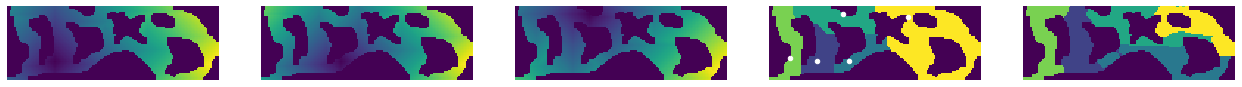

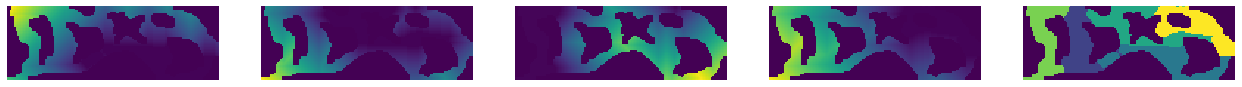

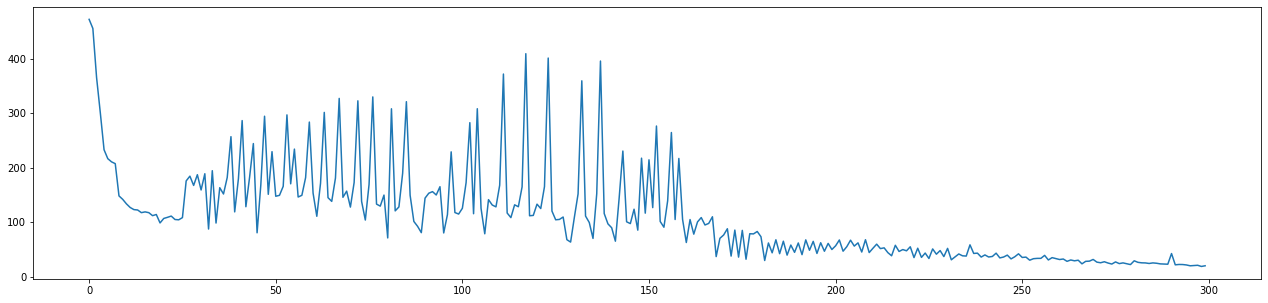

In [44]:
# start_points = [(25, 9), (22, 9), (38, 36), (21, 25), (22, 8)]
start_points=None
A, losses = darp_run(13, 5,epochs=300, start_points=start_points, use_flood=True)

15 :: ----------------------------------
[(0, 55), (37, 34), (42, 6), (25, 114), (18, 112)]
target count  :  [832. 832. 832. 832. 832.]
before darp
current count :  [1121  626  932  746  736]
RMSE :  174.68199678272515


computing flood matrix...



running DARP for 300 epochs...



time taken for 300 epochs : 8905.02 ms

after darp
current_count :  [832 834 832 831 832]
RMSE :  1.0




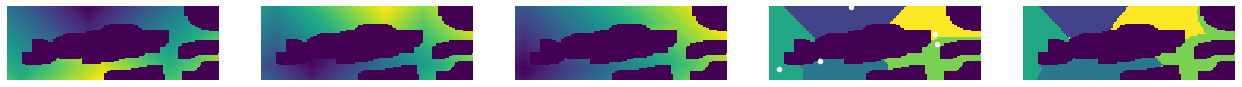

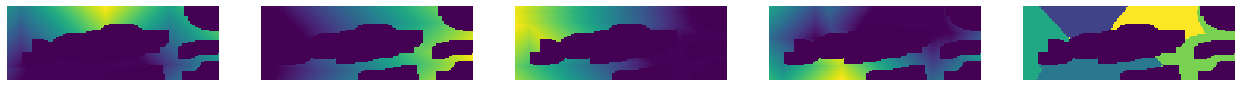

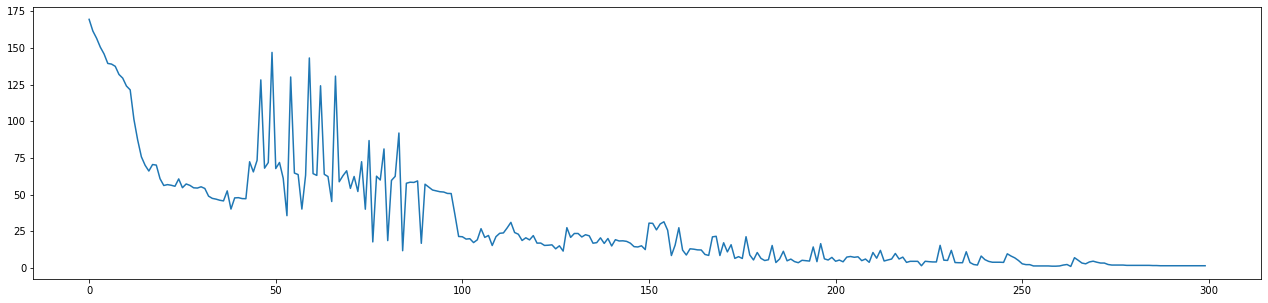

In [45]:
start_points=None
A, losses = darp_run(15, 5,epochs=300, start_points=start_points, use_flood=True)

## Large maps
Without flood matrix

17 :: ----------------------------------
[(72, 138), (10, 101), (33, 131), (112, 149), (134, 194)]
target count  :  [4944. 4944. 4944. 4944. 4944.]
before darp
current count :  [2424 7393 1513 6889 6501]
RMSE :  2462.804742564867


computing flood matrix...



running DARP for 300 epochs...



time taken for 300 epochs : 2213870.09 ms

after darp
current_count :  [4969 4990 4868 4934 4959]
RMSE :  42.0523483291956




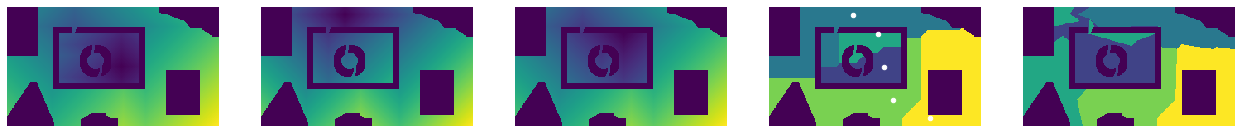

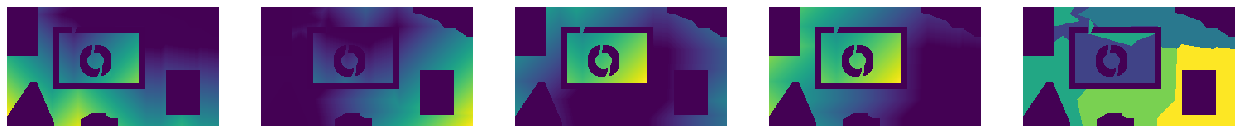

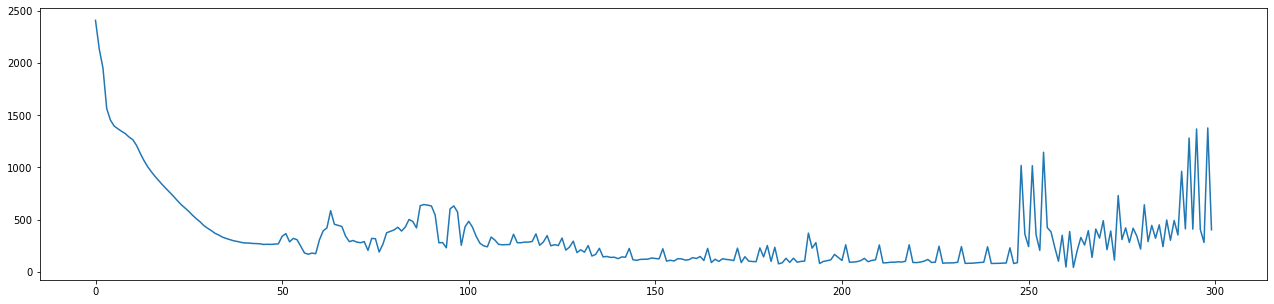

In [49]:
start_points=None
A, losses = darp_run(17, 5,epochs=300, start_points=start_points, use_flood=True)

## With the flood matrix
(Small maps)

0 :: ----------------------------------
[(18, 3), (10, 22), (14, 27), (20, 1)]
target count  :  [179. 179. 179. 179.]
before darp
current count :  [283 310 117   6]
RMSE :  124.24773639789177


computing flood matrix...



running DARP for 300 epochs...



time taken for 300 epochs : 430.70 ms

after darp
current_count :  [179 179 179 179]
RMSE :  0.0




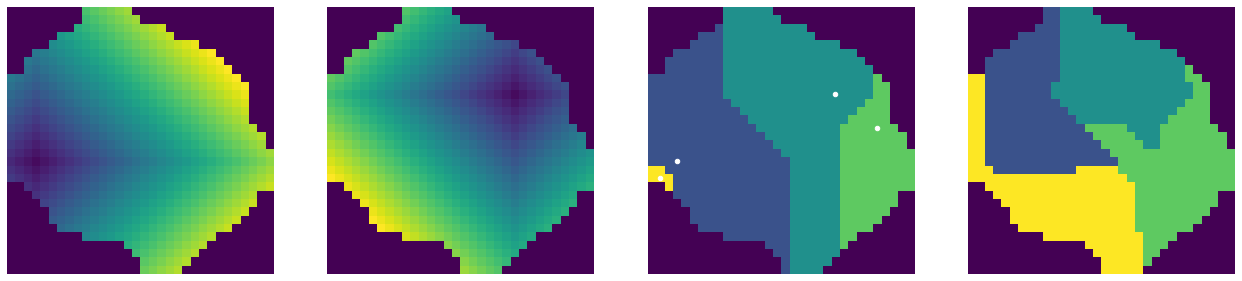

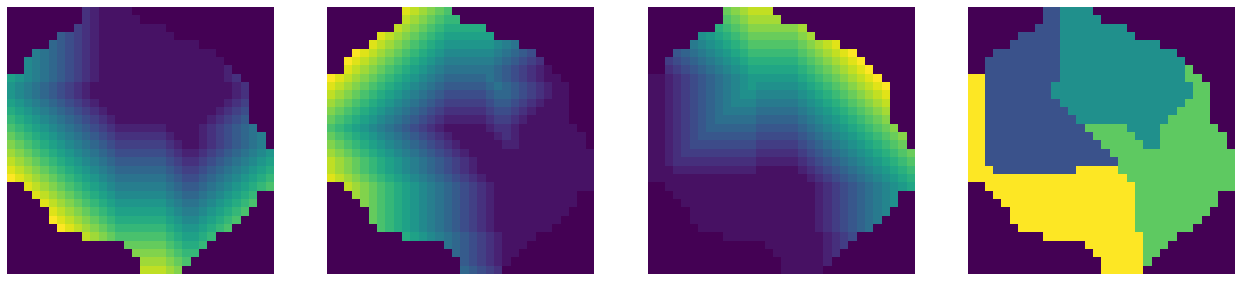

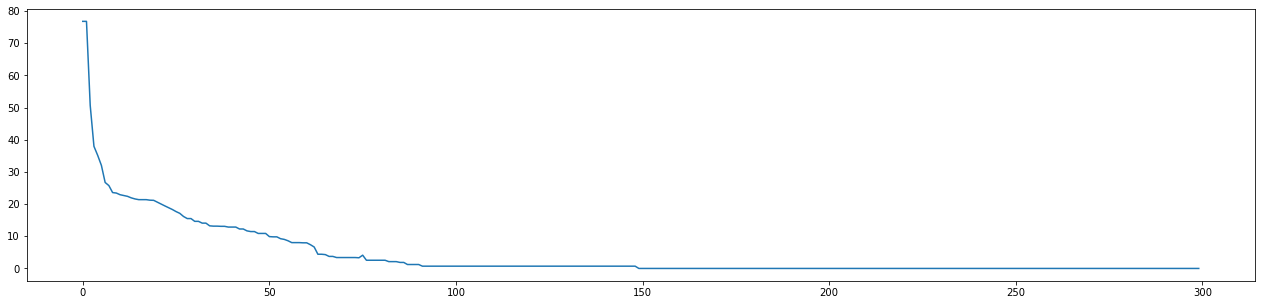

1 :: ----------------------------------
[(26, 4), (5, 5), (6, 14), (27, 10)]
target count  :  [172. 172. 172. 172.]
before darp
current count :  [120 110 202 257]
RMSE :  60.5660796155736


computing flood matrix...



running DARP for 300 epochs...



time taken for 300 epochs : 372.28 ms

after darp
current_count :  [173 172 172 172]
RMSE :  0.5




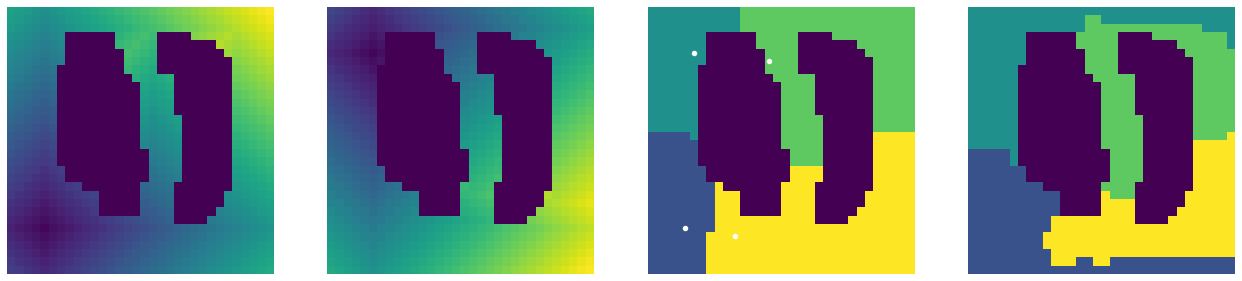

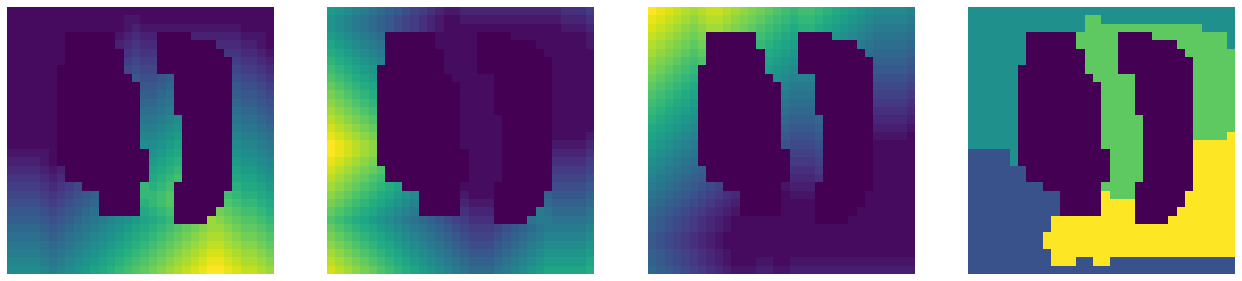

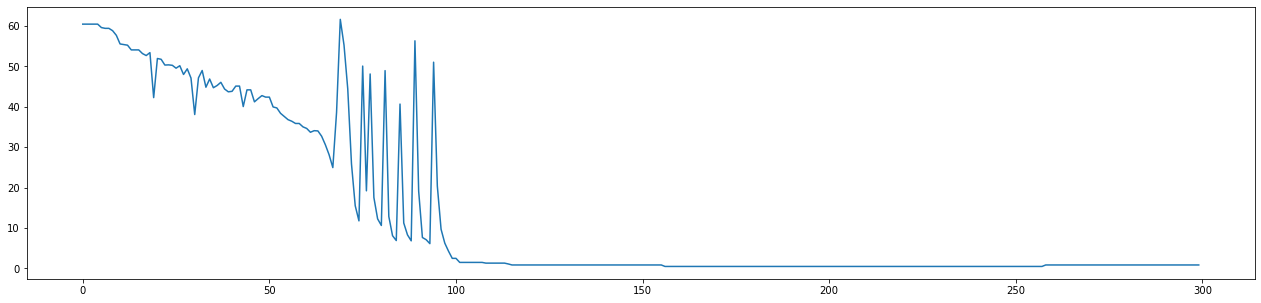

2 :: ----------------------------------
[(2, 18), (11, 17), (29, 15), (2, 20)]
target count  :  [160. 160. 160. 160.]
before darp
current count :  [256 105 182  96]
RMSE :  64.84789896365186


computing flood matrix...



running DARP for 300 epochs...



time taken for 300 epochs : 1413.58 ms

after darp
current_count :  [151 173 144 171]
RMSE :  12.519984025548915




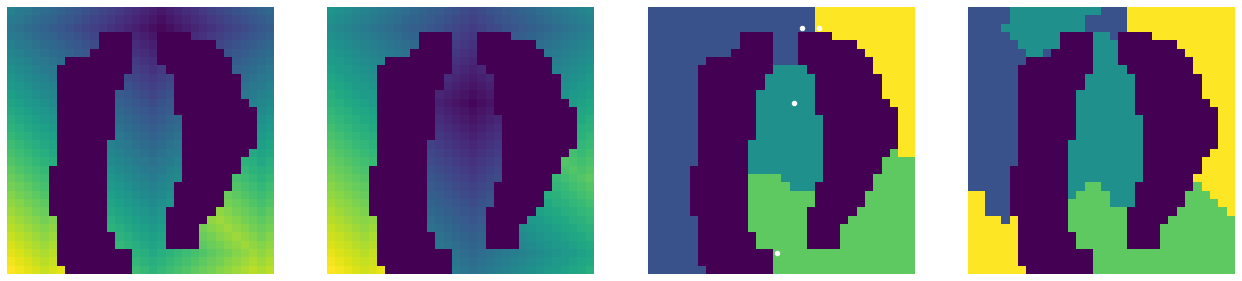

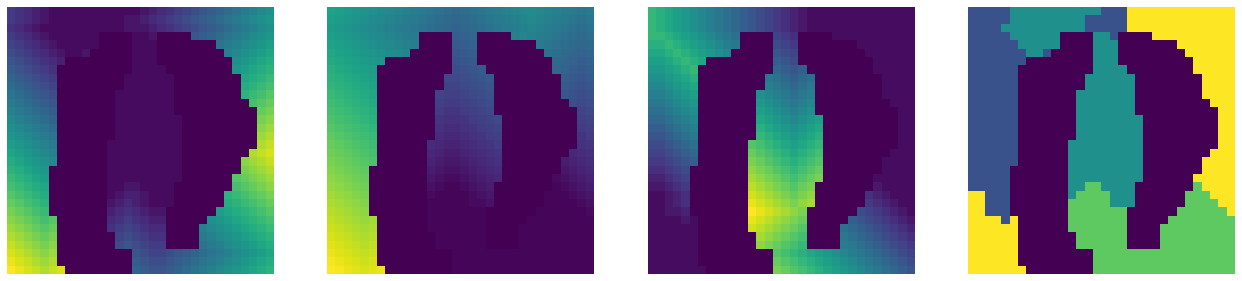

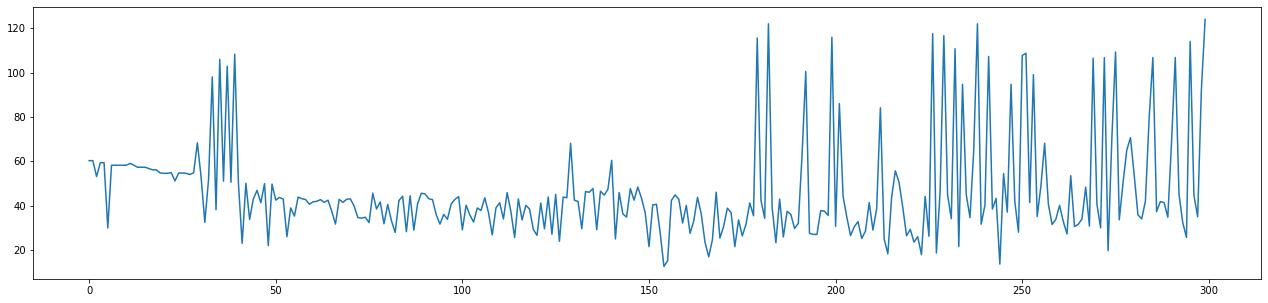

3 :: ----------------------------------
[(12, 3), (30, 30), (26, 29), (24, 17)]
target count  :  [164. 164. 164. 164.]
before darp
current count :  [240  35 142 237]
RMSE :  84.00892809695884


computing flood matrix...



running DARP for 300 epochs...



time taken for 300 epochs : 355.78 ms

after darp
current_count :  [165 164 162 163]
RMSE :  1.224744871391589




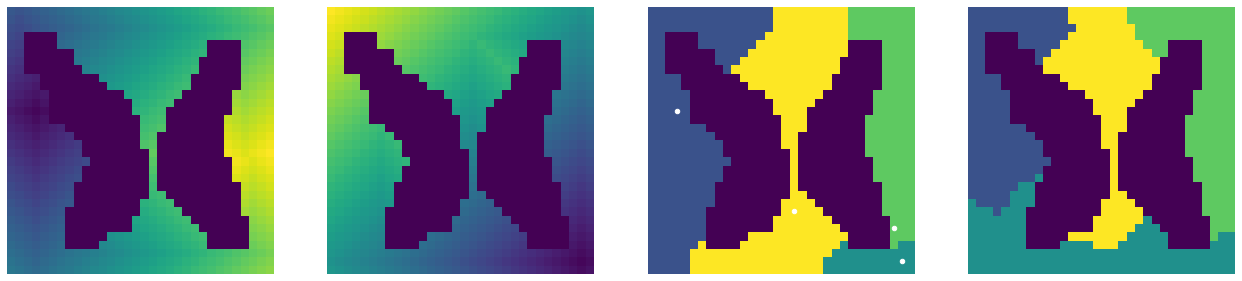

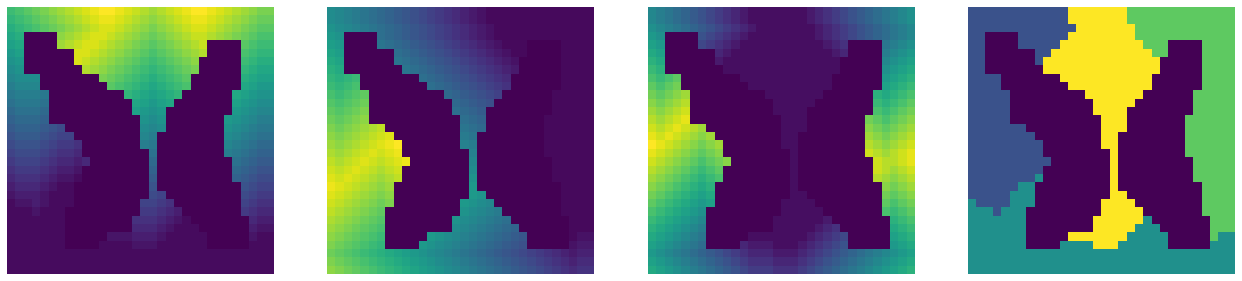

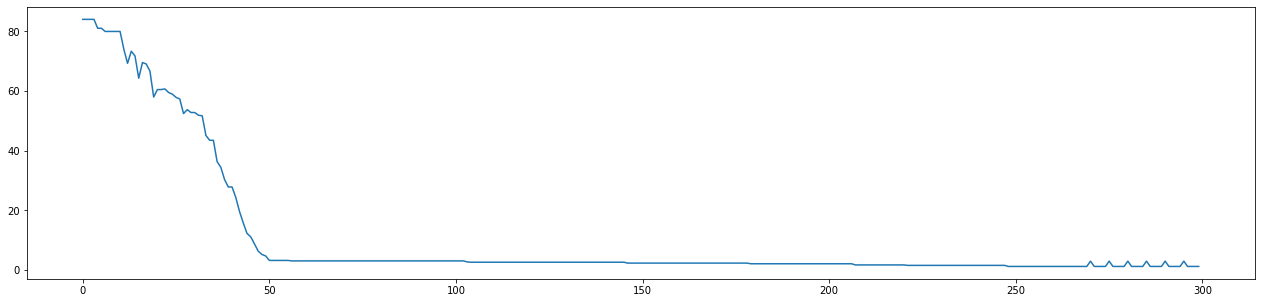

4 :: ----------------------------------
[(31, 6), (27, 22), (31, 9), (20, 24)]
target count  :  [198. 198. 198. 198.]
before darp
current count :  [148 135  99 412]
RMSE :  124.56524394870344


computing flood matrix...



running DARP for 300 epochs...



time taken for 300 epochs : 621.33 ms

after darp
current_count :  [193 204 196 201]
RMSE :  4.301162633521313




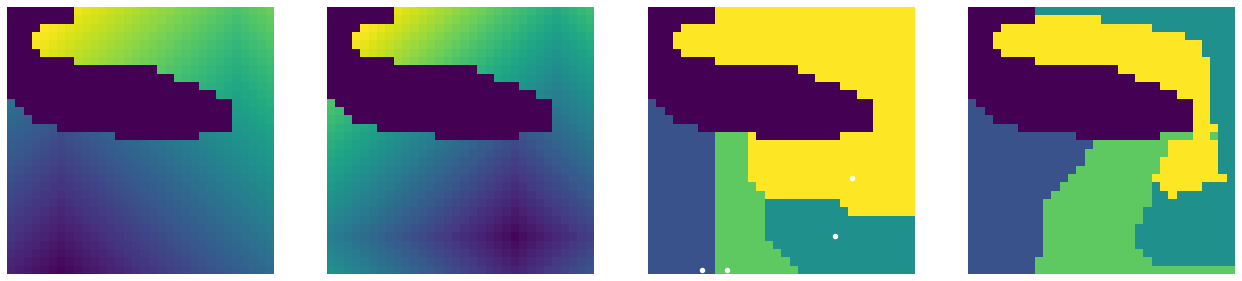

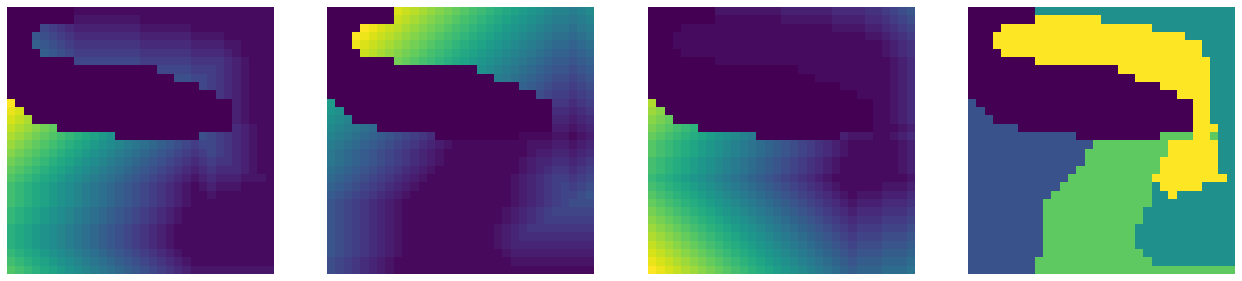

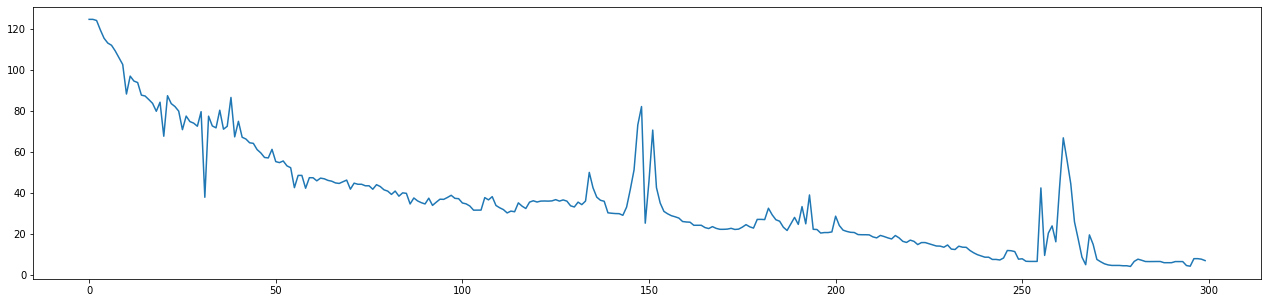

5 :: ----------------------------------
[(16, 11), (20, 24), (12, 7), (26, 31)]
target count  :  [181. 181. 181. 181.]
before darp
current count :  [255 232 170  68]
RMSE :  72.39993093919358


computing flood matrix...



running DARP for 300 epochs...



time taken for 300 epochs : 848.55 ms

after darp
current_count :  [178 185 184 178]
RMSE :  3.278719262151




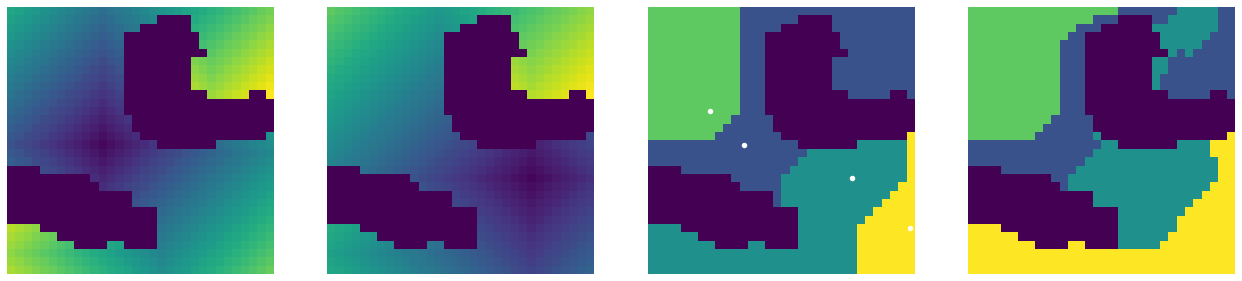

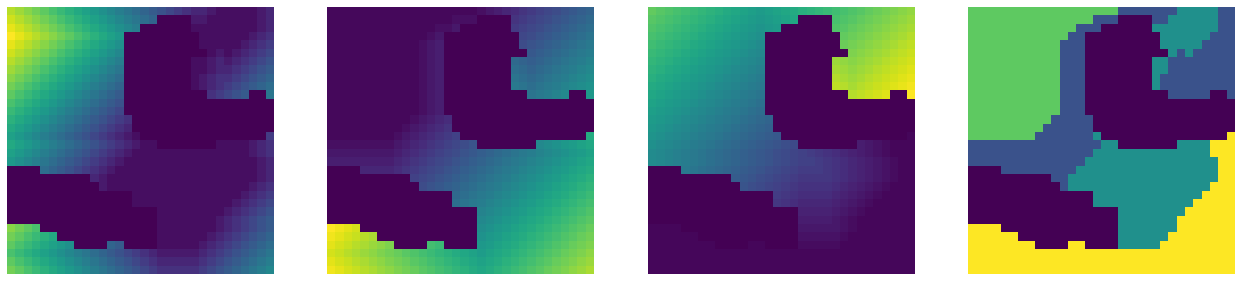

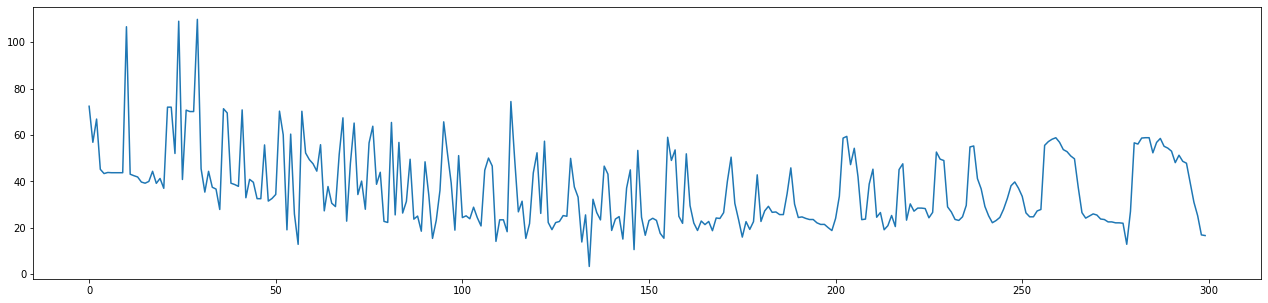

6 :: ----------------------------------
[(2, 2), (24, 3), (1, 13), (18, 27)]
target count  :  [181. 181. 181. 181.]
before darp
current count :  [116 238 117 252]
RMSE :  64.44183423832689


computing flood matrix...



running DARP for 300 epochs...



time taken for 300 epochs : 370.18 ms

after darp
current_count :  [182 181 179 181]
RMSE :  1.118033988749895




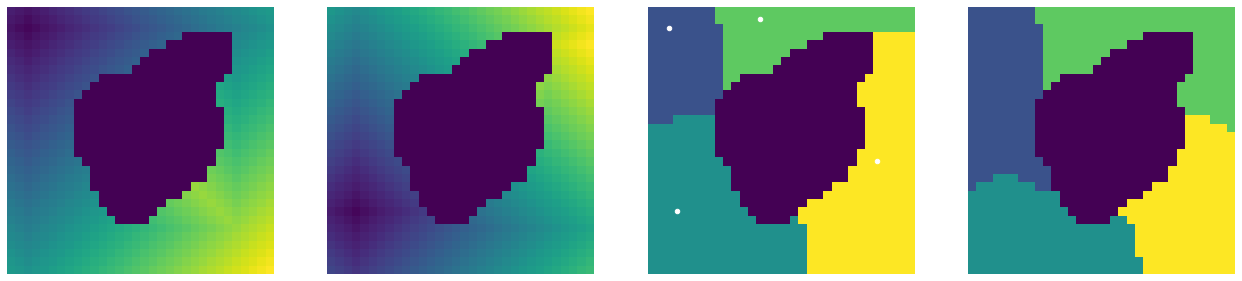

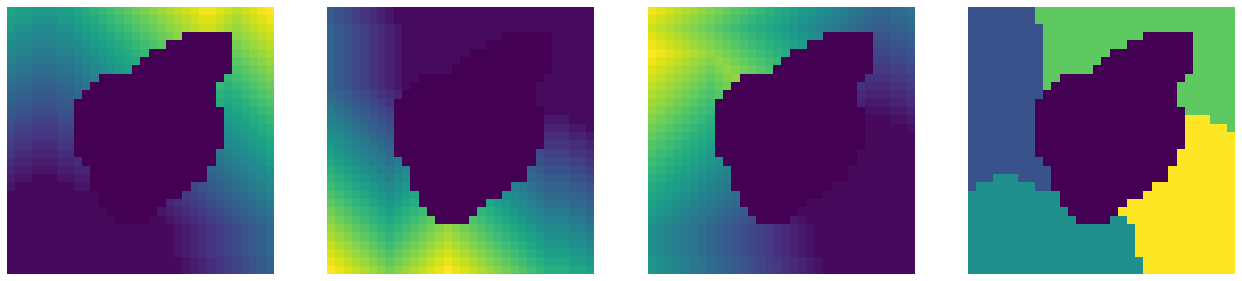

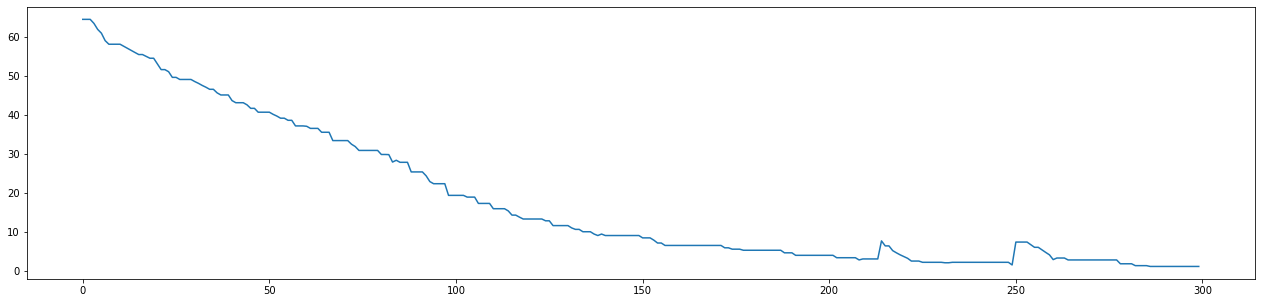

7 :: ----------------------------------
[(4, 14), (21, 0), (26, 2), (17, 20)]
target count  :  [152. 152. 152. 152.]
before darp
current count :  [119  25 105 361]
RMSE :  125.60652849274993


computing flood matrix...



running DARP for 300 epochs...



time taken for 300 epochs : 484.14 ms

after darp
current_count :  [152 153 152 153]
RMSE :  0.7071067811865476




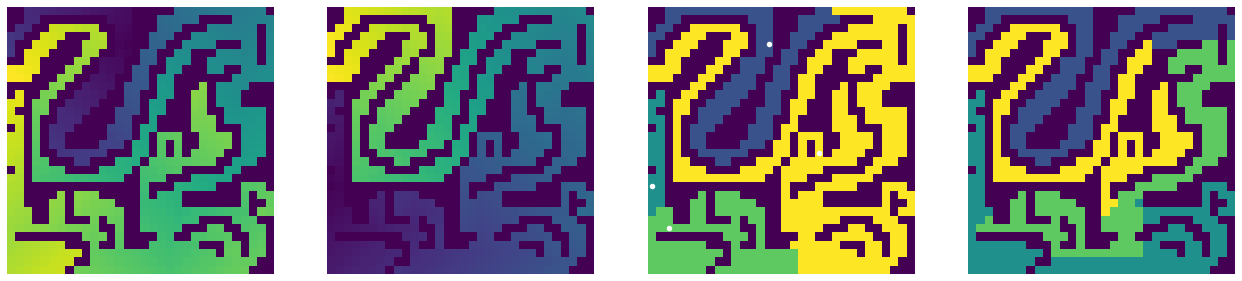

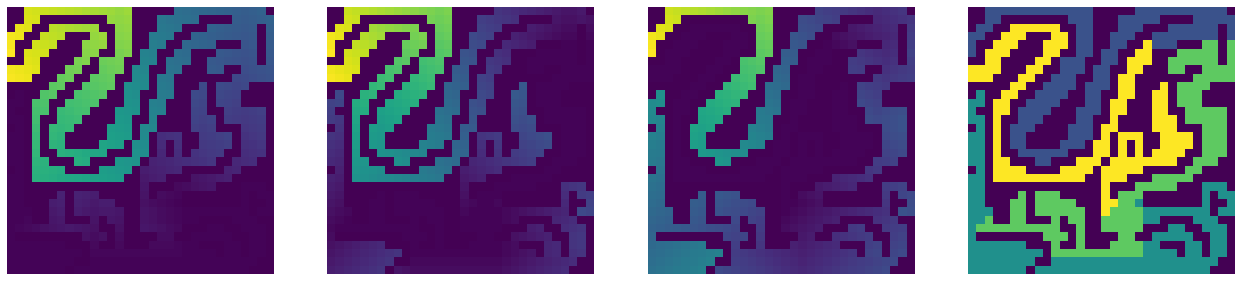

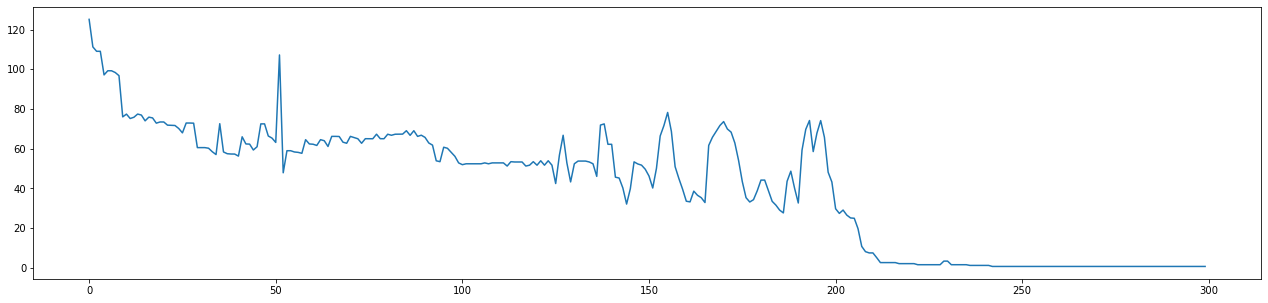

8 :: ----------------------------------
[(21, 30), (19, 4), (8, 24), (9, 6)]
target count  :  [193. 193. 193. 193.]
before darp
current count :  [284 112 233 143]
RMSE :  68.81496930174423


computing flood matrix...



running DARP for 300 epochs...



time taken for 300 epochs : 1258.70 ms

after darp
current_count :  [242 169 208 153]
RMSE :  34.64823227814083




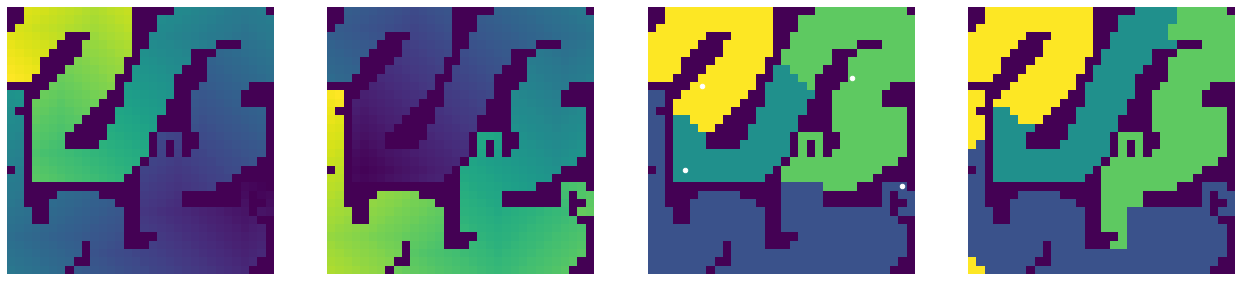

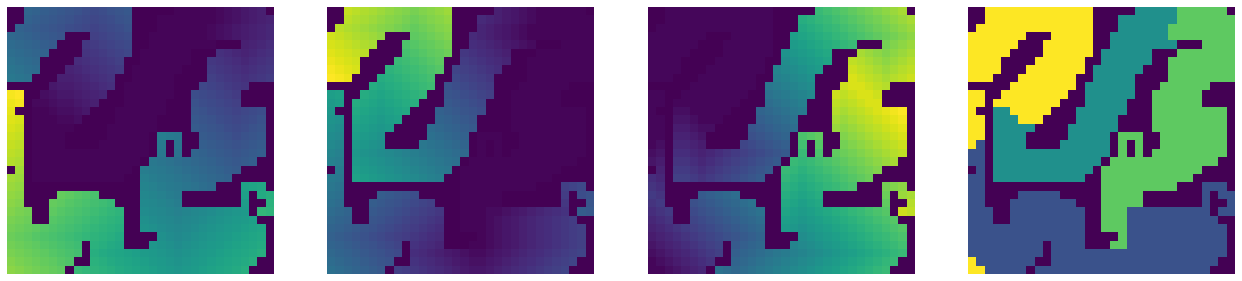

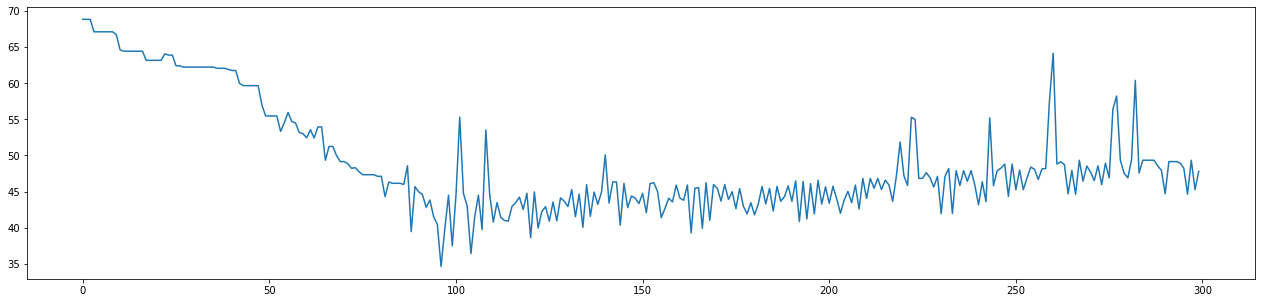

9 :: ----------------------------------
[(19, 49), (26, 7), (41, 13), (3, 30)]
target count  :  [382. 382. 382. 382.]
before darp
current count :  [378 298 417 436]
RMSE :  52.945726928620026


computing flood matrix...



running DARP for 300 epochs...



time taken for 300 epochs : 709.95 ms

after darp
current_count :  [381 382 385 381]
RMSE :  1.6583123951777




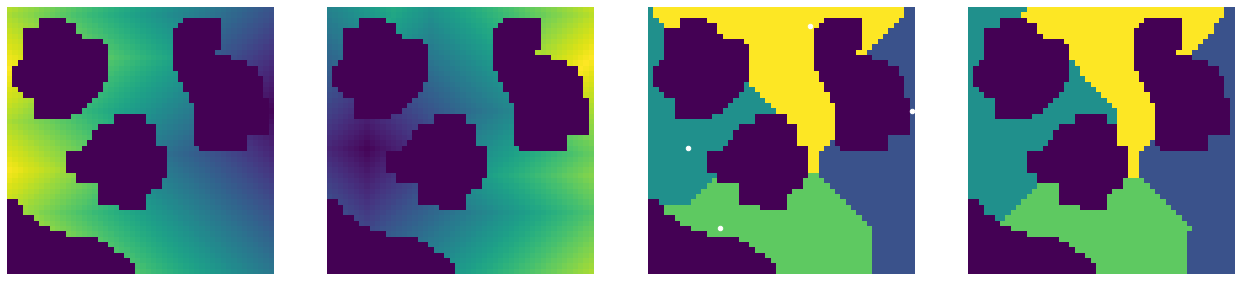

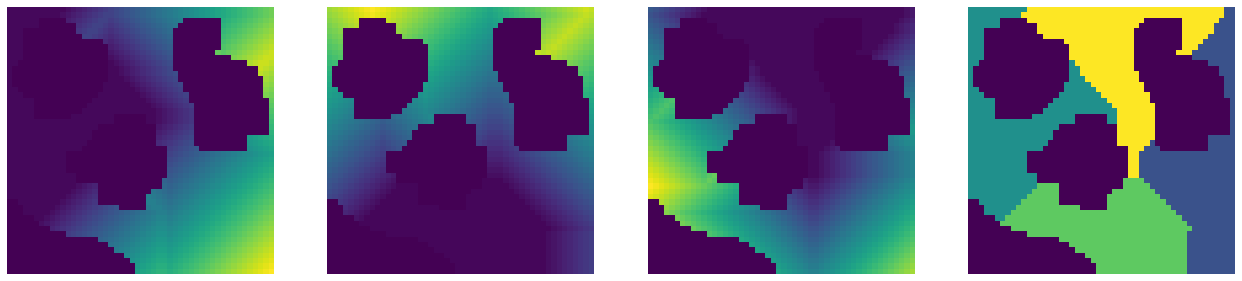

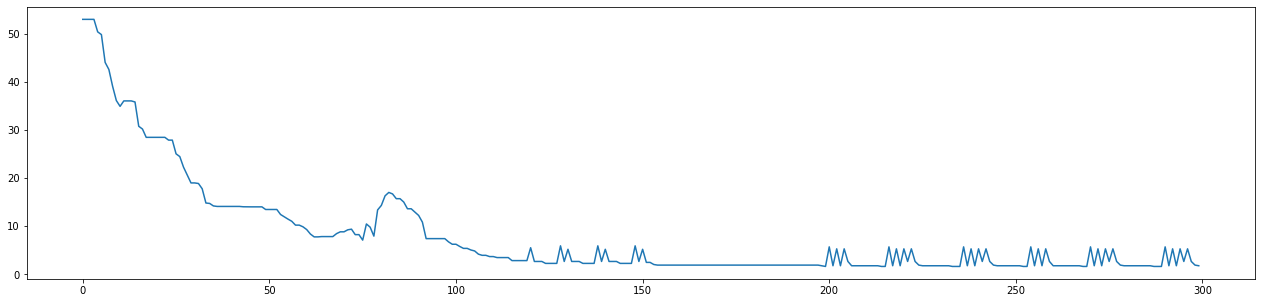

10 :: ----------------------------------
[(39, 29), (11, 10), (39, 36), (3, 32)]
target count  :  [330. 330. 330. 330.]
before darp
current count :  [376 287 360 295]
RMSE :  39.01922603025334


computing flood matrix...



running DARP for 300 epochs...



time taken for 300 epochs : 652.18 ms

after darp
current_count :  [340 312 349 317]
RMSE :  15.443445211480501




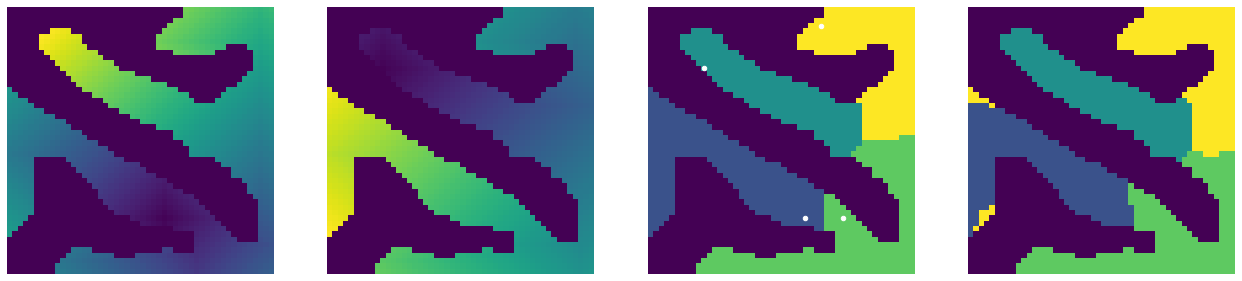

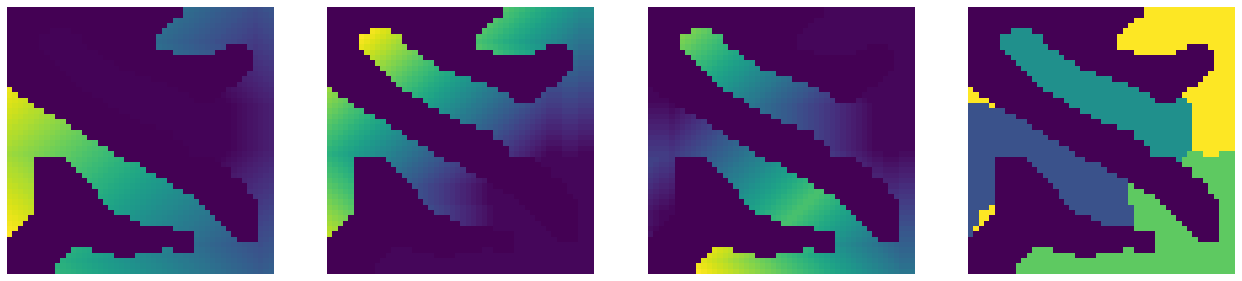

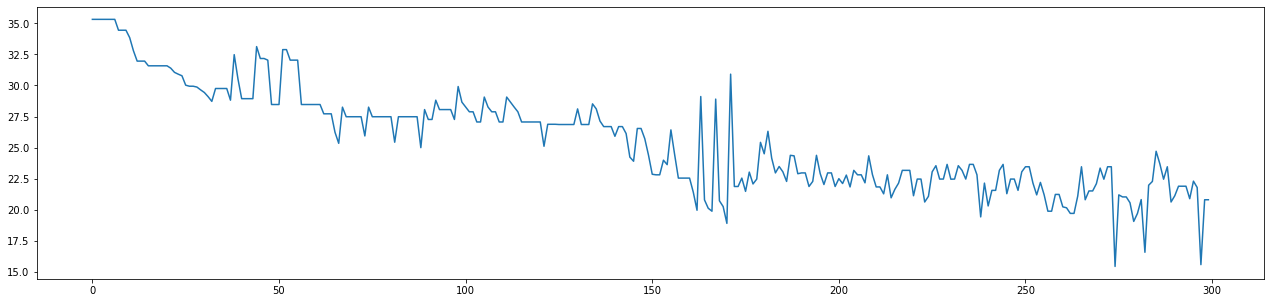

In [43]:
for i in range(11):
    A, losses = darp_run(i, 4, epochs=300, start_points=start_points, use_flood=True)

## Without the Flood Matrix

0 :: ----------------------------------
[(25, 11), (22, 24), (2, 14), (20, 2)]
target count  :  [179. 179. 179. 179.]
before darp
current count :  [164 234 196 122]
RMSE :  41.19465984809196

running DARP for 300 epochs...



time taken for 300 epochs : 312.47 ms

after darp
current_count :  [179 179 179 179]
RMSE :  0.0




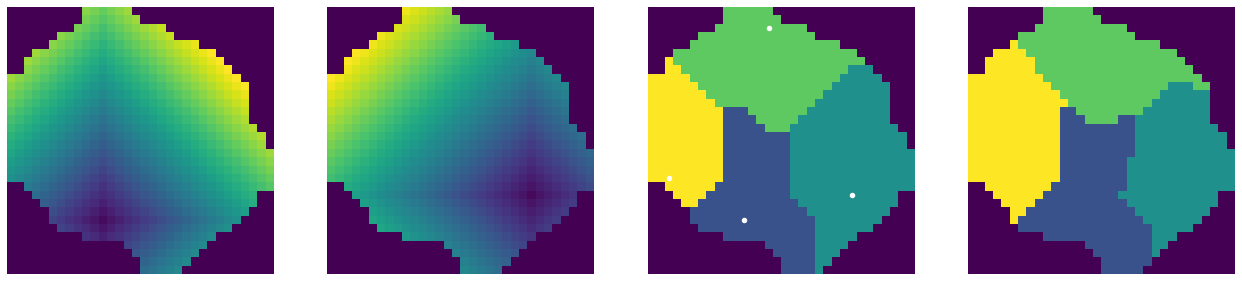

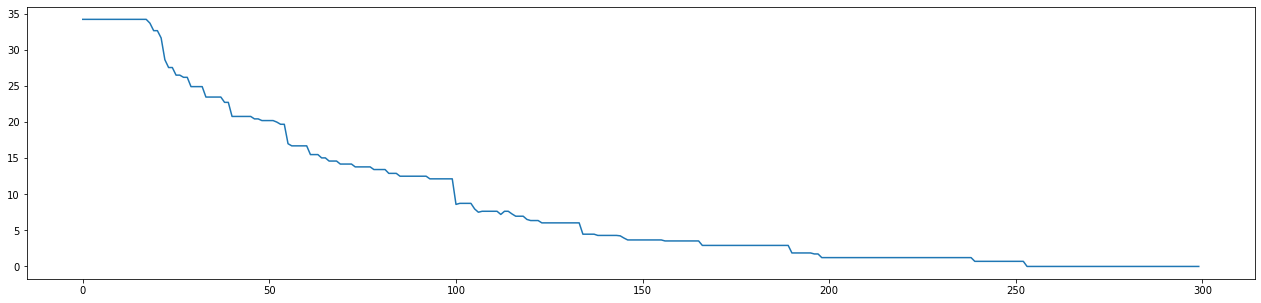

1 :: ----------------------------------
[(7, 14), (13, 28), (30, 29), (0, 19)]
target count  :  [172. 172. 172. 172.]
before darp
current count :  [238 104 279  68]
RMSE :  88.38127629764124

running DARP for 300 epochs...



time taken for 300 epochs : 332.65 ms

after darp
current_count :  [172 172 172 173]
RMSE :  0.5




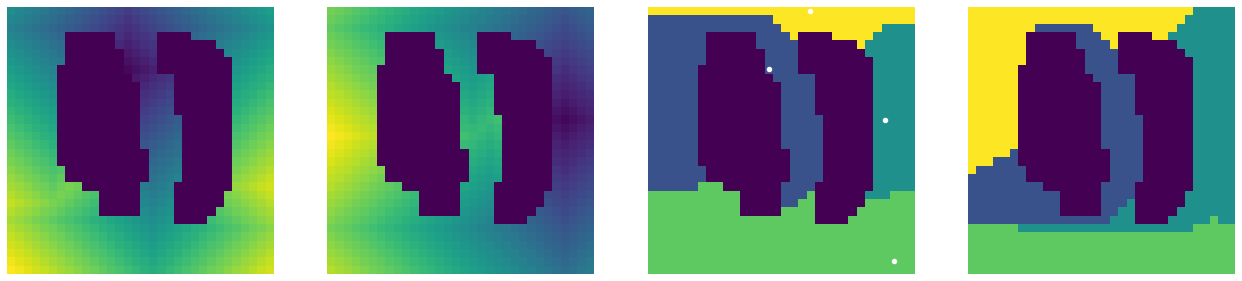

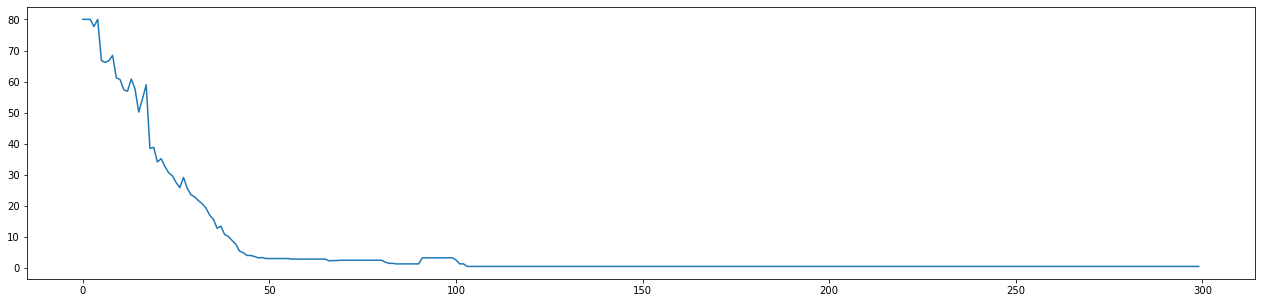

2 :: ----------------------------------
[(7, 15), (15, 18), (11, 14), (24, 28)]
target count  :  [160. 160. 160. 160.]
before darp
current count :  [331 140  20 148]
RMSE :  111.11368052584704

running DARP for 300 epochs...



time taken for 300 epochs : 1999.44 ms

after darp
current_count :  [147 180 134 178]
RMSE :  19.80530232033836




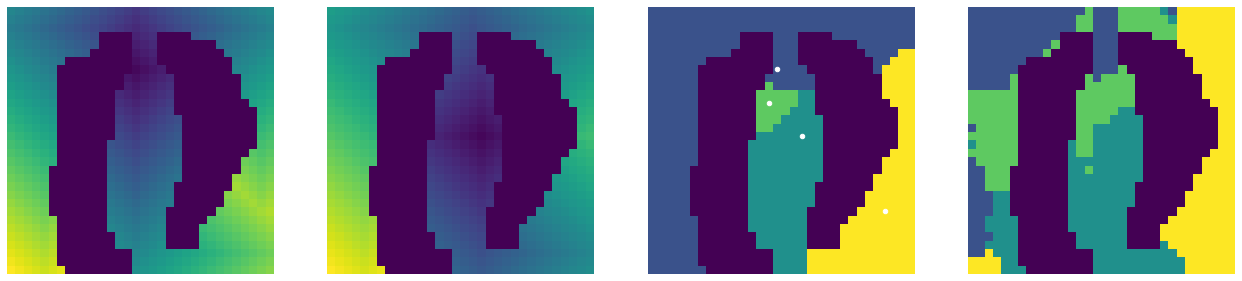

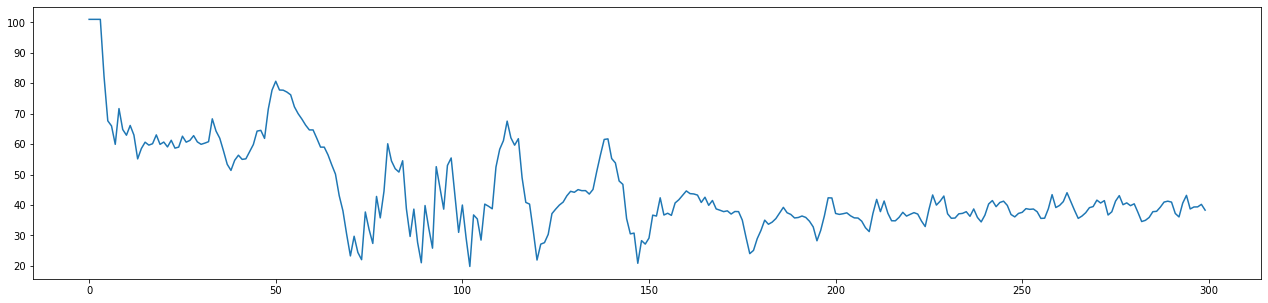

3 :: ----------------------------------
[(25, 18), (30, 18), (13, 31), (20, 3)]
target count  :  [164. 164. 164. 164.]
before darp
current count :  [167  96 174 217]
RMSE :  43.422344478390386

running DARP for 300 epochs...



time taken for 300 epochs : 318.08 ms

after darp
current_count :  [164 163 163 164]
RMSE :  0.7071067811865476




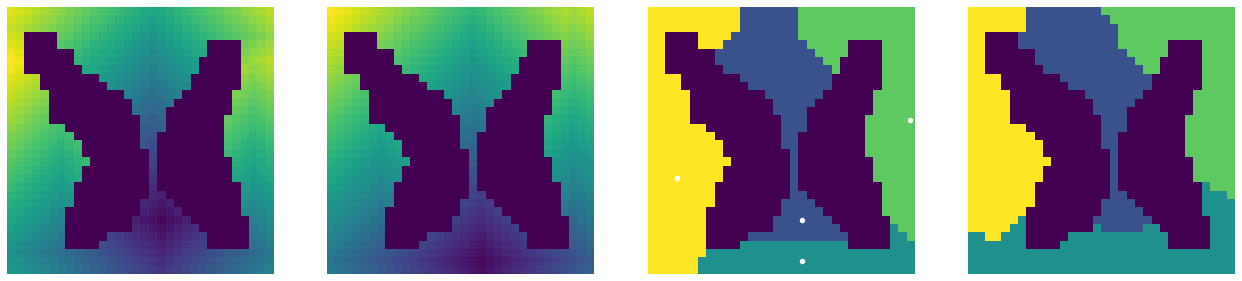

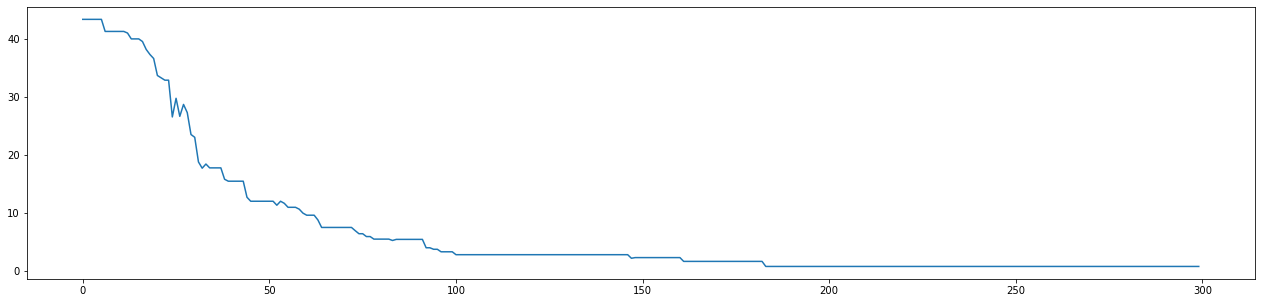

4 :: ----------------------------------
[(6, 28), (20, 5), (16, 11), (27, 22)]
target count  :  [198. 198. 198. 198.]
before darp
current count :  [278 185 101 230]
RMSE :  65.19585876418839

running DARP for 300 epochs...



time taken for 300 epochs : 975.41 ms

after darp
current_count :  [213 197 194 190]
RMSE :  8.74642784226795




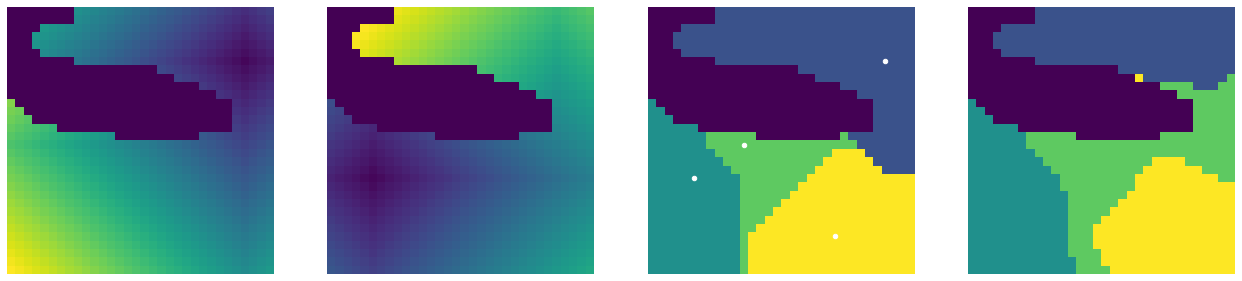

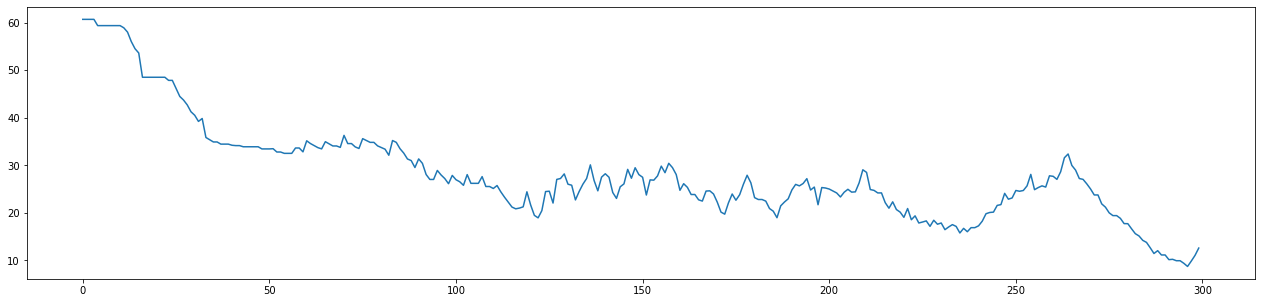

5 :: ----------------------------------
[(1, 6), (10, 25), (28, 26), (6, 7)]
target count  :  [181. 181. 181. 181.]
before darp
current count :  [ 76 103 313 233]
RMSE :  96.48445470644481

running DARP for 300 epochs...



time taken for 300 epochs : 1443.69 ms

after darp
current_count :  [182 168 188 187]
RMSE :  7.984359711335656




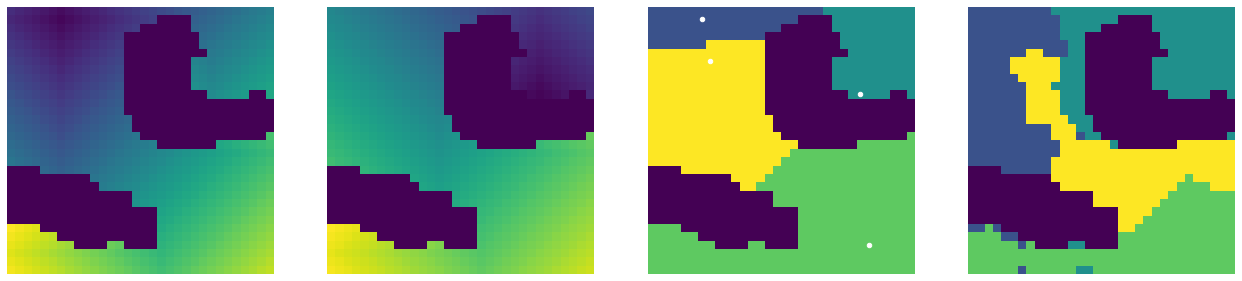

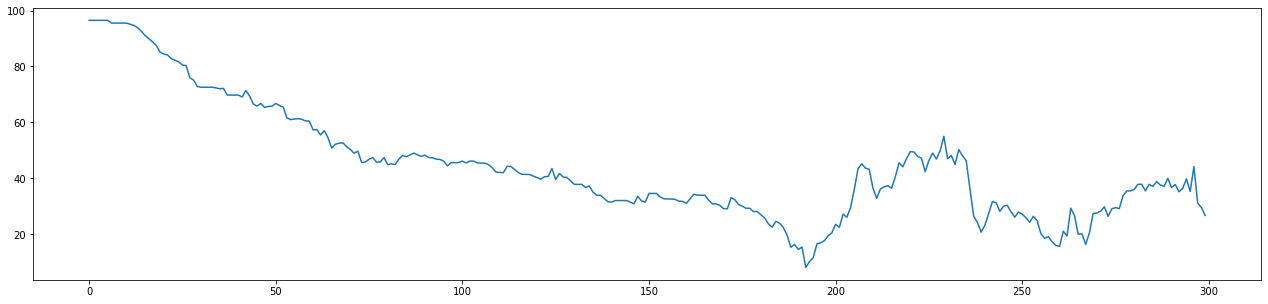

6 :: ----------------------------------
[(26, 3), (26, 10), (4, 1), (21, 2)]
target count  :  [181. 181. 181. 181.]
before darp
current count :  [ 60 316 262  85]
RMSE :  110.27579063420947

running DARP for 300 epochs...



time taken for 300 epochs : 842.45 ms

after darp
current_count :  [181 180 180 182]
RMSE :  0.8660254037844386




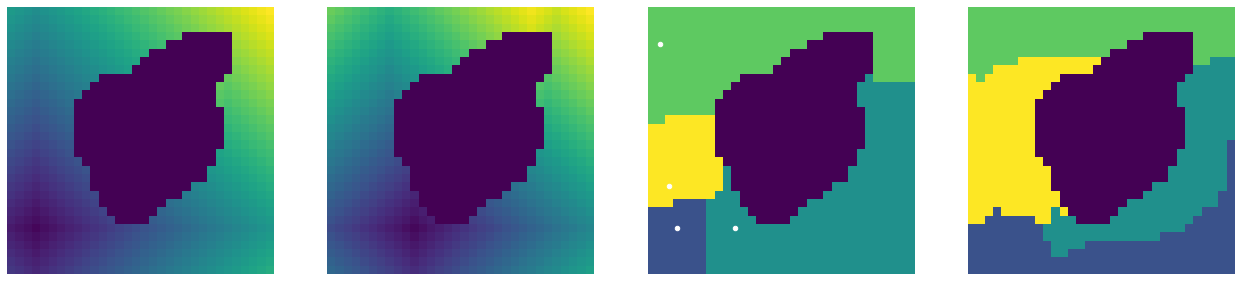

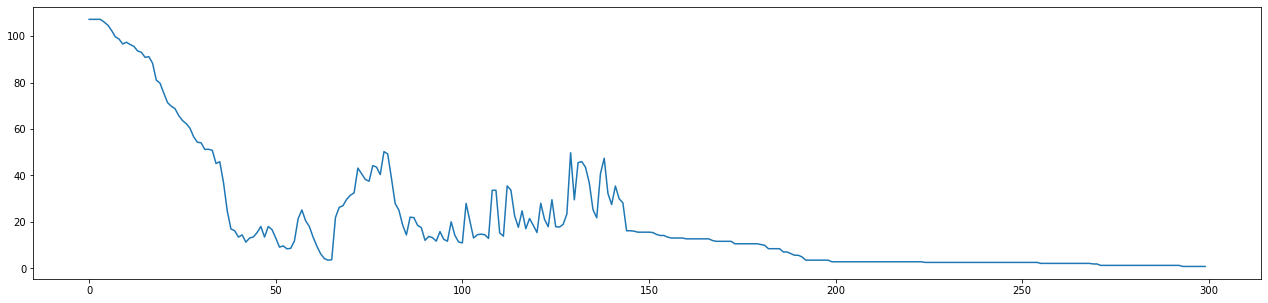

7 :: ----------------------------------
[(4, 9), (30, 19), (12, 29), (16, 6)]
target count  :  [152. 152. 152. 152.]
before darp
current count :  [ 77 291 134 108]
RMSE :  82.47120709678015

running DARP for 300 epochs...



time taken for 300 epochs : 1571.94 ms

after darp
current_count :  [149 182 142 137]
RMSE :  17.564168070250297




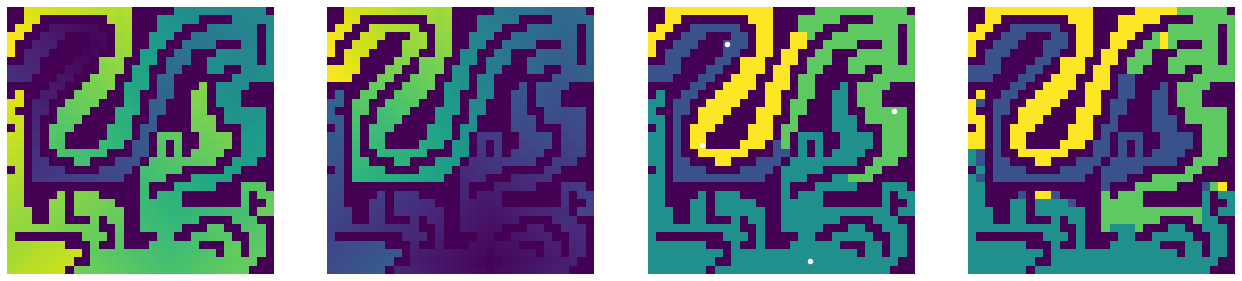

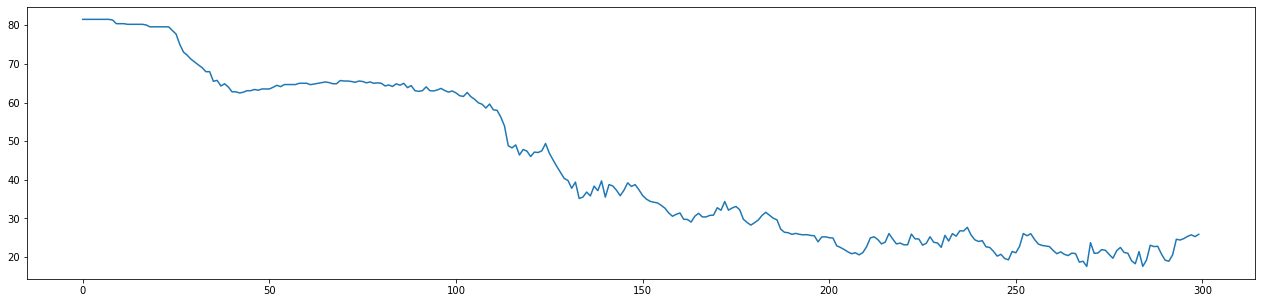

8 :: ----------------------------------
[(12, 0), (2, 5), (10, 0), (20, 12)]
target count  :  [193. 193. 193. 193.]
before darp
current count :  [324 123   2 323]
RMSE :  137.33353559855655

running DARP for 300 epochs...



time taken for 300 epochs : 2840.29 ms

after darp
current_count :  [230 236  53 253]
RMSE :  81.26807491260021




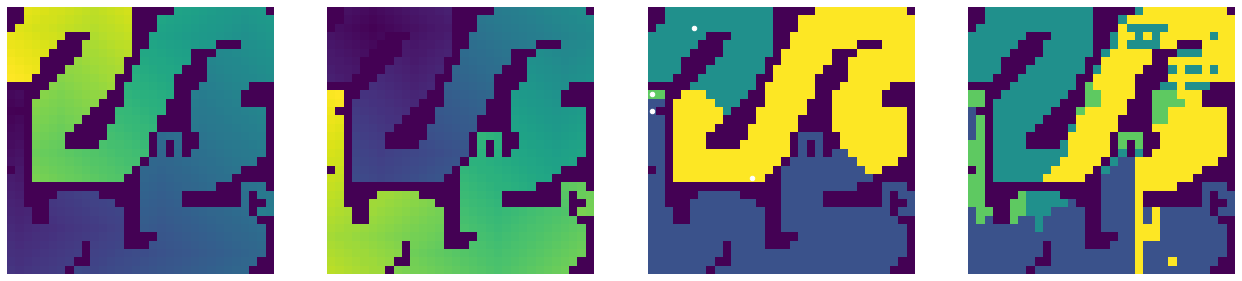

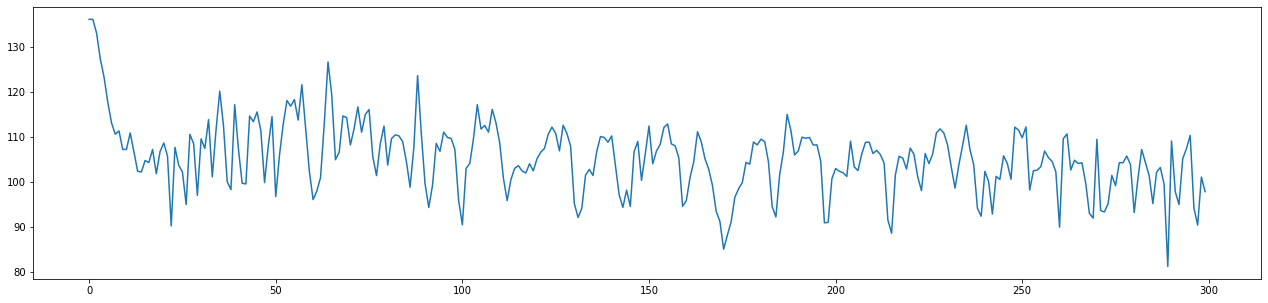

9 :: ----------------------------------
[(13, 23), (21, 6), (47, 44), (18, 24)]
target count  :  [382. 382. 382. 382.]
before darp
current count :  [380 392 562 195]
RMSE :  129.8778272069563

running DARP for 300 epochs...



time taken for 300 epochs : 1213.53 ms

after darp
current_count :  [383 382 382 382]
RMSE :  0.5




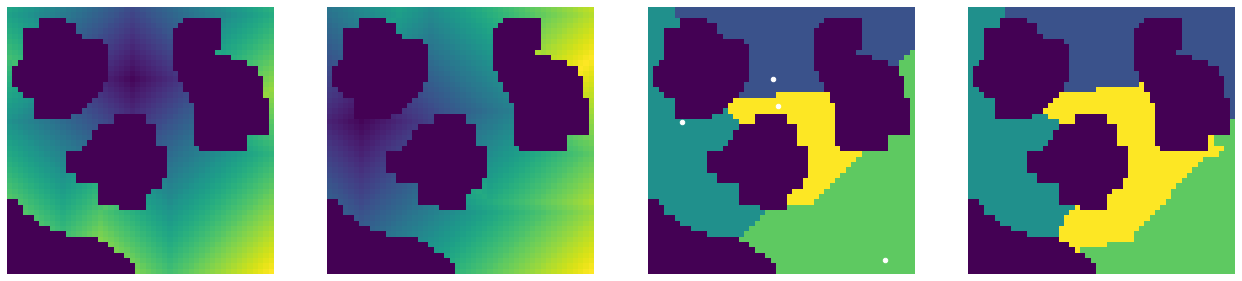

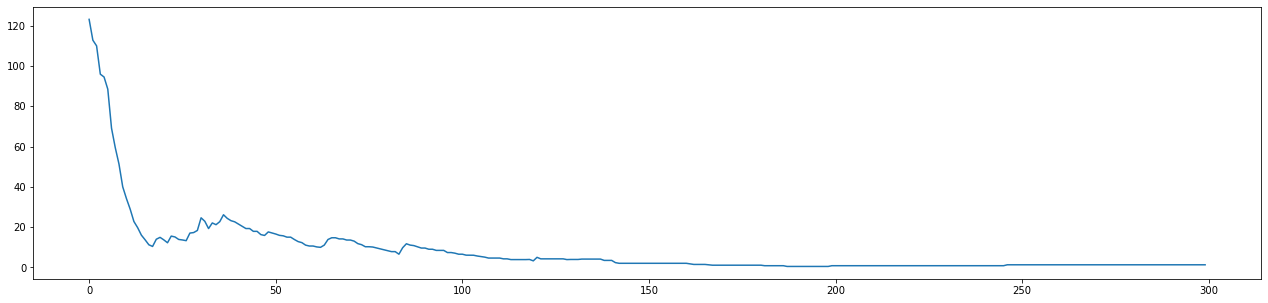

10 :: ----------------------------------
[(3, 40), (18, 0), (22, 31), (46, 48)]
target count  :  [330. 330. 330. 330.]
before darp
current count :  [213 283 415 407]
RMSE :  85.22323626805074

running DARP for 300 epochs...



time taken for 300 epochs : 576.74 ms

after darp
current_count :  [328 333 328 329]
RMSE :  2.1213203435596424




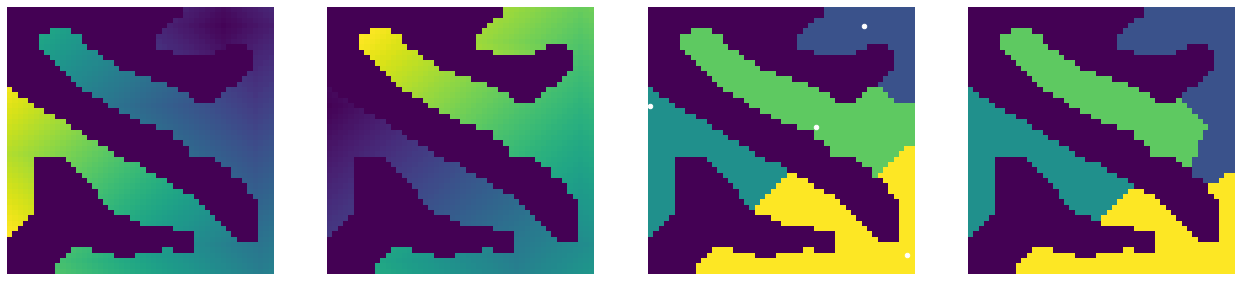

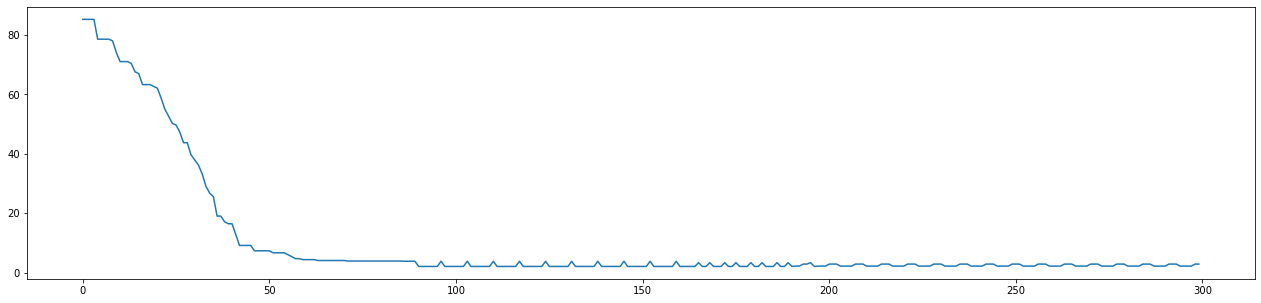

In [46]:
for i in range(11):
    A, losses = darp_run(i, 4, epochs=300, start_points=start_points, use_flood=False)